In [51]:
import os
import sys
from pathlib import Path

root_path = '../..'
training_path = root_path + '/02_training/matching_networks'
data_path = root_path + '/01_data_preparation/omniglot'

sys.path.append(training_path)

import torch
from torch.autograd import Variable 
from torchsummary import summary
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
import seaborn as sns
from PIL import Image

from model import MatchingNetwork

In [13]:
def processes_batch(data, mu, sigma):
    return (data - mu) / sigma

def load_checkpoint(best=False):    
    model = MatchingNetwork(keep_prob=0.0, batch_size=20, num_channels=1, 
                            learning_rate=1e-3, fce=True, num_classes_per_set=20, 
                            num_samples_per_class=1, image_size=28)
    
    model_path = training_path + "/ckpt/"
    print("[*] Loading model from {}".format(model_path))

    filename = 'model_ckpt.tar'
    if best:
        filename = 'best_model_ckpt.tar'
        
    ckpt_path = os.path.join(model_path, filename)
    
    if torch.cuda.is_available():
        ckpt = torch.load(ckpt_path)
    else:
        ckpt = torch.load(ckpt_path, map_location=torch.device('cpu'))

    # load variables from checkpoint
    start_epoch = ckpt['epoch']
    best_valid_acc = ckpt['best_valid_acc']
    model.load_state_dict(ckpt['model_state'])
    #optimizer.load_state_dict(ckpt['optim_state'])

    if best:
        print(
            "[*] Loaded {} checkpoint @ epoch {} "
            "with best valid acc of {:.3f}".format(
                filename, ckpt['epoch'], ckpt['best_valid_acc'])
        )
    else:
        print(
            "[*] Loaded {} checkpoint @ epoch {}".format(
                filename, ckpt['epoch'])
        )
    return model

## Loading Model

In [12]:
model = load_checkpoint(best=True)
model

[*] Loading model from ../../02_training/matching_networks/ckpt/
[*] Loaded best_model_ckpt.tar checkpoint @ epoch 99 with best valid acc of 0.910


MatchingNetwork(
  (g): Embeddings_extractor(
    (layer1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.0, inplace=False)
    )
    (layer2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.0, inplace=False)
    )
    (layer3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPoo

## Loading data

In [34]:
def load_alphabet_data(alphabet_name='Avesta'):
    alphabet_path = data_path + '/data/evaluation/' + alphabet_name
    
    character_folders = [f for f in os.listdir(alphabet_path) if os.path.isdir(alphabet_path + '/' + f)]
    
    images = []
    labels = []
    for character_folder in character_folders:
        files = [f for f in os.listdir(alphabet_path + '/' + character_folder) \
                 if os.path.isfile(alphabet_path + '/' + character_folder + '/' + f)]
        for file_name in files:
            image = Image.open(alphabet_path  + '/' + character_folder + '/' + file_name)
            image = image.resize((28, 28))
            image = np.asarray(image)

            images.append(image)
            labels.append(int(character_folder[-2:]))
    return np.array(images),  np.array(labels)

In [56]:
images, labels = load_alphabet_data('Avesta')
images = images.reshape(images.shape[0], 1, images.shape[1], images.shape[2])
images = (images - np.mean(images)) / np.std(images)

In [57]:
images.shape

(520, 1, 28, 28)

In [58]:
labels.shape

(520,)

In [59]:
images.size

407680

## Generating Embeddings

In [68]:
embeddings = []
tensor_image = Variable(torch.from_numpy(images[:, :, :, :])).float()
embeddings = model.g(tensor_image)
embeddings = embeddings.detach().numpy()

embeddings.shape

(520, 64)

## Alphabet: Avesta

In [69]:
def plot_embeddings(embedding_2d, labels, alphabet, title_complement=''):
    #markers = {0: "o", 1: "D"}
    #style = (labels.astype(int) % 2 == 0).astype(int)
    style = labels
    markers = {l: f'${l:.0f}$' for l in np.unique(labels)}
    fig, ax = plt.subplots(figsize=(7, 5))
    ax = sns.scatterplot(x=embedding_2d[:,0], y=embedding_2d[:,1], 
                         style=style, linewidth=0, hue=labels.astype(str),
                         markers=markers, legend=False, s=120)
    ax.set_title(alphabet + title_complement, size=14)
    
    plt.show()

#images = images.reshape(config.n_embeddings, 105, 105)
#embeddings = embeddings.reshape(config.n_embeddings, -1)
#labels = labels.reshape(config.n_embeddings)

## Matching NN Embedding

Number of iterations: 4999


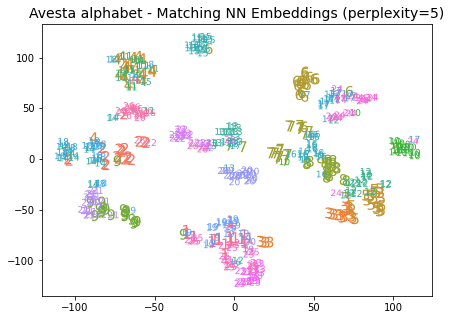

Number of iterations: 4999


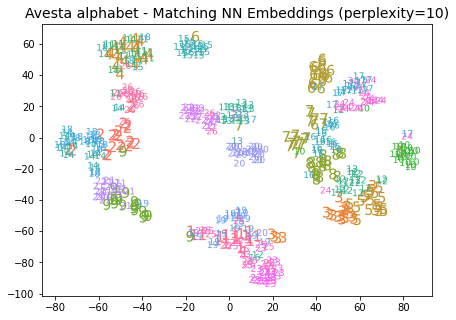

Number of iterations: 4999


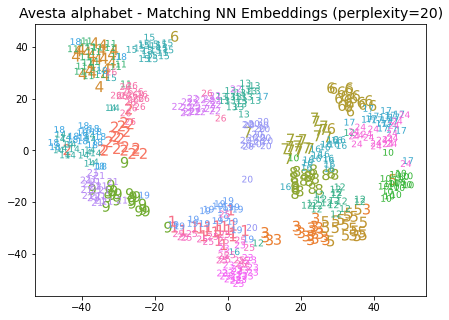

Number of iterations: 1649


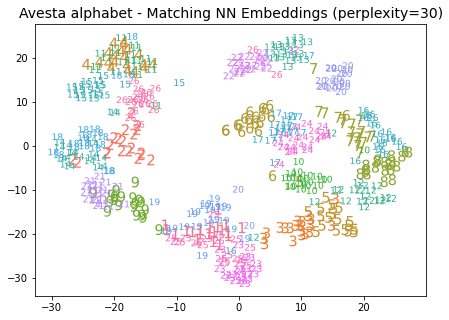

Number of iterations: 1799


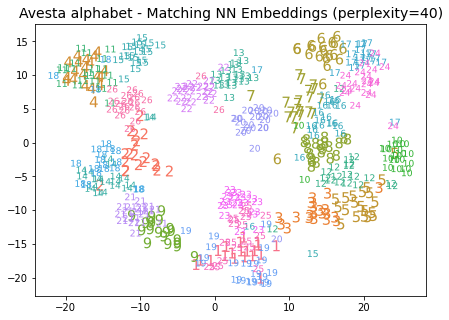

Number of iterations: 2399


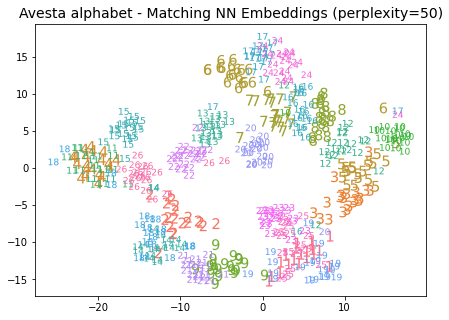

In [104]:
perplexity = [5, 10, 20, 30, 40, 50]

for p in perplexity:
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=p, n_iter=5000)
    embeddings_2d = tsne.fit_transform(embeddings)
    print(f'Number of iterations: {tsne.n_iter_}')
    plot_embeddings(embeddings_2d, labels, 'Avesta', f' alphabet - Matching NN Embeddings (perplexity={p})')

In [105]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=50, n_iter=5000)
embeddings_2d = tsne.fit_transform(embeddings)

In [106]:
tsne.n_iter_

2399

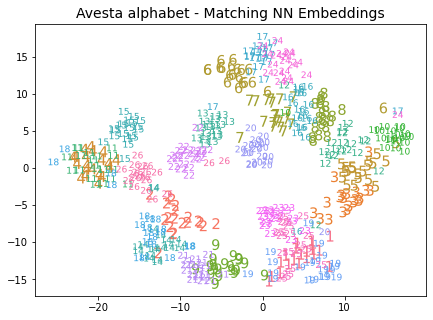

In [107]:
plot_embeddings(embeddings_2d, labels, 'Avesta', ' alphabet - Matching NN Embeddings')

## Original Embedding

Number of iterations: 4999


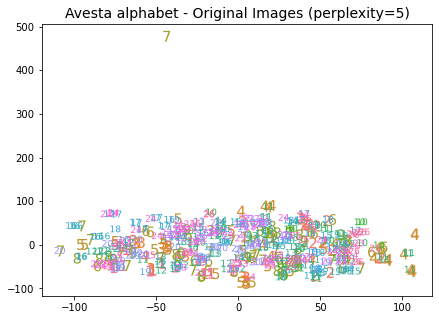

Number of iterations: 4749


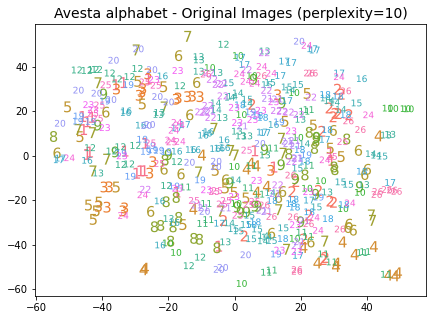

Number of iterations: 2599


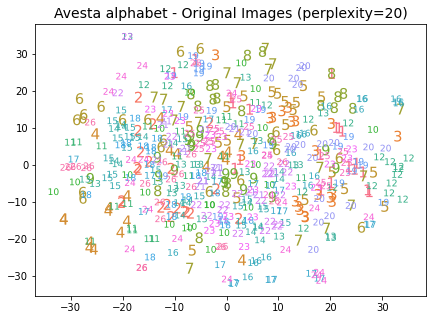

Number of iterations: 3049


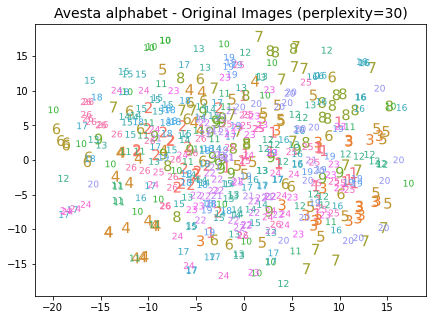

Number of iterations: 1949


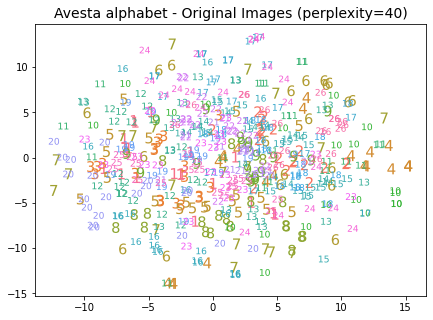

Number of iterations: 2649


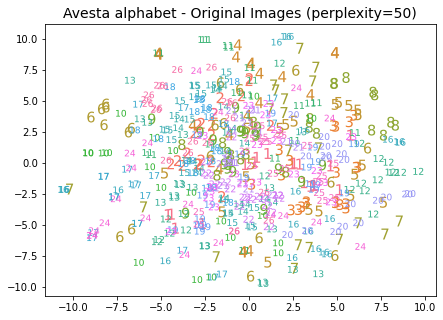

In [108]:
perplexity = [5, 10, 20, 30, 40, 50]

for p in perplexity:
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=p, n_iter=5000)
    embeddings_2d = tsne.fit_transform(images.reshape(embeddings.shape[0], -1))
    print(f'Number of iterations: {tsne.n_iter_}')
    plot_embeddings(embeddings_2d, labels, 'Avesta', f' alphabet - Original Images (perplexity={p})')

In [109]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=50, n_iter=5000)
embeddings_2d = tsne.fit_transform(images.reshape(images.shape[0], -1))

In [110]:
tsne.n_iter_

2649

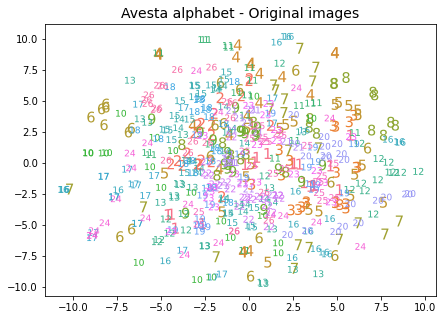

In [111]:
plot_embeddings(embeddings_2d, labels, 'Avesta', ' alphabet - Original images')